In [8]:
import os
import torch
import numpy as np
from torch.nn.functional import softmax
import pandas as pd

import pytorch_lightning as pl
from pytorch_lightning import loggers as pl_loggers

from train.sequence import ClassificationWrapper
from transformers import AutoModelForSequenceClassification
from data.dataset import get_dataloaders

from sklearn.metrics import f1_score, balanced_accuracy_score, precision_score, recall_score, confusion_matrix
import pickle

In [6]:
data_path = "../data/"
device = "gpu"

paths = []
for root, dirs, files in os.walk("/home/rasteiger/datasets/dslab/logs/initial"):
    for file in files:
        if file.endswith(".ckpt"):
            paths.append((os.path.join(root, file), file))

In [3]:
print(paths)

[('/home/rasteiger/datasets/dslab/logs/initial/version_bs=8_lr=1e-05_cw=None/checkpoints/epoch=2-step=35034.ckpt', 'epoch=2-step=35034.ckpt'), ('/home/rasteiger/datasets/dslab/logs/initial/version_bs=8_lr=5e-05_cw=tensor([1.0000, 4.6097])/checkpoints/epoch=2-step=35034.ckpt', 'epoch=2-step=35034.ckpt'), ('/home/rasteiger/datasets/dslab/logs/initial/version_bs=8_lr=5e-05_cw=None/checkpoints/epoch=2-step=35034.ckpt', 'epoch=2-step=35034.ckpt'), ('/home/rasteiger/datasets/dslab/logs/initial/version_bs=8_lr=0.0001_cw=tensor([1.0000, 4.6097])/checkpoints/epoch=2-step=35034.ckpt', 'epoch=2-step=35034.ckpt'), ('/home/rasteiger/datasets/dslab/logs/initial/version_bs=8_lr=0.0001_cw=None/checkpoints/epoch=2-step=35034.ckpt', 'epoch=2-step=35034.ckpt'), ('/home/rasteiger/datasets/dslab/logs/initial/version_bs=16_lr=1e-05_cw=tensor([1.0000, 4.6097])/checkpoints/epoch=2-step=17517.ckpt', 'epoch=2-step=17517.ckpt'), ('/home/rasteiger/datasets/dslab/logs/initial/version_bs=16_lr=1e-05_cw=None/checkpo

In [10]:
model_name = "unitary/multilingual-toxic-xlm-roberta"
class_weight = torch.tensor([1.0, 4.60967657991111])
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2, ignore_mismatched_sizes=True)
criterion = torch.nn.CrossEntropyLoss(weight=class_weight)

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at unitary/multilingual-toxic-xlm-roberta and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([1, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([1]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [57]:
def calculate_metrics(model_name, predictions, labels):
    scores = ['f1', 'precision', 'recall']
    params = ['micro', 'macro', 'weighted', 'binary']
    columns = ['model','accuracy'] + [score + '_' + param for score in scores for param in params]
    df = pd.DataFrame(0, index = [0], columns=columns)
    df.iloc[0, 0] = model_name
    df.iloc[0, 1] = balanced_accuracy_score(predictions, labels)
    i = 2
    for param in params:
        df.loc[0, scores[0] + '_' + param] = f1_score(predictions, labels, average=param)
        df.loc[0, scores[1] + '_' + param] = precision_score(predictions, labels, average=param)
        df.loc[0, scores[2] + '_' + param] = recall_score(predictions, labels, average=param)
        i=i+3

    return df

In [8]:
_, eval_loader = get_dataloaders(model_name=model_name, data_path=data_path, use_cache=True, batch_size=32)
trainer = pl.Trainer(accelerator="gpu", devices=1, logger=False, precision='16-mixed')

label_list=[]
for data in eval_loader:
    label_list.append(data['labels'].numpy())
labels = np.concatenate(label_list, axis=-1)

res = []
res_vals = {}

for p, f in paths:

    # very beautiful solution, I know
    try:
        wrapper = ClassificationWrapper.load_from_checkpoint(p, model=model, loss=criterion)
    except:
        wrapper = ClassificationWrapper.load_from_checkpoint(p, model=model, loss=torch.nn.CrossEntropyLoss())
    
    outputs = trainer.predict(wrapper, eval_loader)
    
    probabilities = np.concatenate([softmax(x['logits'].float(), dim=-1).numpy() for x in outputs])
    predictions = np.argmax(probabilities, axis=-1)

    res_vals[p] = (probabilities, predictions, labels)

Map:   0%|          | 0/373684 [00:00<?, ? examples/s]

Map:   0%|          | 0/41521 [00:00<?, ? examples/s]

/home/rasteiger/miniconda3/envs/dslab/lib/python3.8/site-packages/lightning_fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python3.8 /home/rasteiger/miniconda3/envs/dslab/lib/python3 ...
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to

/home/rasteiger/datasets/dslab/logs/initial/version_bs=8_lr=1e-05_cw=None/checkpoints/epoch=2-step=35034.ckpt epoch=2-step=35034.ckpt


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLE

Predicting: |                                                                                     | 0/? [00:00…

/home/rasteiger/datasets/dslab/logs/initial/version_bs=8_lr=5e-05_cw=tensor([1.0000, 4.6097])/checkpoints/epoch=2-step=35034.ckpt epoch=2-step=35034.ckpt


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLE

Predicting: |                                                                                     | 0/? [00:00…

TOKENIZERS_PARALLELISM=(true | false)


/home/rasteiger/datasets/dslab/logs/initial/version_bs=8_lr=5e-05_cw=None/checkpoints/epoch=2-step=35034.ckpt epoch=2-step=35034.ckpt


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLE

Predicting: |                                                                                     | 0/? [00:00…

TOKENIZERS_PARALLELISM=(true | false)
TOKENIZERS_PARALLELISM=(true | false)
TOKENIZERS_PARALLELISM=(true | false)


/home/rasteiger/datasets/dslab/logs/initial/version_bs=8_lr=0.0001_cw=tensor([1.0000, 4.6097])/checkpoints/epoch=2-step=35034.ckpt epoch=2-step=35034.ckpt


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLE

Predicting: |                                                                                     | 0/? [00:00…

/home/rasteiger/datasets/dslab/logs/initial/version_bs=8_lr=0.0001_cw=None/checkpoints/epoch=2-step=35034.ckpt epoch=2-step=35034.ckpt


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLE

Predicting: |                                                                                     | 0/? [00:00…

/home/rasteiger/datasets/dslab/logs/initial/version_bs=16_lr=1e-05_cw=tensor([1.0000, 4.6097])/checkpoints/epoch=2-step=17517.ckpt epoch=2-step=17517.ckpt


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLE

Predicting: |                                                                                            | 0/?…

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/home/rasteiger/datasets/dslab/logs/initial/version_bs=16_lr=1e-05_cw=None/checkpoints/epoch=2-step=17517.ckpt epoch=2-step=17517.ckpt


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLE

Predicting: |                                                                                            | 0/?…

/home/rasteiger/datasets/dslab/logs/initial/version_bs=16_lr=5e-05_cw=tensor([1.0000, 4.6097])/checkpoints/epoch=2-step=17517.ckpt epoch=2-step=17517.ckpt


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLE

Predicting: |                                                                                            | 0/?…

/home/rasteiger/datasets/dslab/logs/initial/version_bs=16_lr=5e-05_cw=None/checkpoints/epoch=2-step=17517.ckpt epoch=2-step=17517.ckpt


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLE

Predicting: |                                                                                            | 0/?…

TOKENIZERS_PARALLELISM=(true | false)


/home/rasteiger/datasets/dslab/logs/initial/version_bs=16_lr=0.0001_cw=tensor([1.0000, 4.6097])/checkpoints/epoch=2-step=17517.ckpt epoch=2-step=17517.ckpt


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLE

Predicting: |                                                                                            | 0/?…

TOKENIZERS_PARALLELISM=(true | false)


/home/rasteiger/datasets/dslab/logs/initial/version_bs=16_lr=0.0001_cw=None/checkpoints/epoch=2-step=17517.ckpt epoch=2-step=17517.ckpt


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLE

Predicting: |                                                                                            | 0/?…

/home/rasteiger/datasets/dslab/logs/initial/version_bs=32_lr=1e-05_cw=tensor([1.0000, 4.6097])/checkpoints/epoch=2-step=8760.ckpt epoch=2-step=8760.ckpt


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLE

Predicting: |                                                                                            | 0/?…

/home/rasteiger/datasets/dslab/logs/initial/version_bs=32_lr=1e-05_cw=None/checkpoints/epoch=2-step=8760.ckpt epoch=2-step=8760.ckpt


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLE

Predicting: |                                                                                            | 0/?…

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/home/rasteiger/datasets/dslab/logs/initial/version_bs=32_lr=5e-05_cw=tensor([1.0000, 4.6097])/checkpoints/epoch=2-step=8760.ckpt epoch=2-step=8760.ckpt


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLE

Predicting: |                                                                                            | 0/?…

TOKENIZERS_PARALLELISM=(true | false)


/home/rasteiger/datasets/dslab/logs/initial/version_bs=32_lr=5e-05_cw=None/checkpoints/epoch=2-step=8760.ckpt epoch=2-step=8760.ckpt


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLE

Predicting: |                                                                                            | 0/?…

TOKENIZERS_PARALLELISM=(true | false)


/home/rasteiger/datasets/dslab/logs/initial/version_bs=32_lr=0.0001_cw=tensor([1.0000, 4.6097])/checkpoints/epoch=2-step=8760.ckpt epoch=2-step=8760.ckpt


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLE

Predicting: |                                                                                            | 0/?…

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/home/rasteiger/datasets/dslab/logs/initial/version_bs=32_lr=0.0001_cw=None/checkpoints/epoch=2-step=8760.ckpt epoch=2-step=8760.ckpt


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLE

Predicting: |                                                                                            | 0/?…

TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [9]:
with open(data_path + 'preds.pkl', 'wb') as f:
    pickle.dump(res_vals, f)

In [ ]:
with open(data_path + 'preds.pkl', 'rb') as f:
    res_vals = pickle.load(f)

In [12]:
for p, (probabilities, predictions, labels) in res_vals.items():

    metrics = calculate_metrics(p, predictions, labels)
    
    res.append(metrics)

/home/rasteiger/miniconda3/envs/dslab/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rasteiger/miniconda3/envs/dslab/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rasteiger/miniconda3/envs/dslab/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rasteiger/miniconda3/envs/dslab/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-define

In [14]:
res

[                                               model  accuracy  f1_micro  \
 0  /home/rasteiger/datasets/dslab/logs/initial/ve...  0.771744  0.860577   
 
    f1_macro  f1_weighted  f1_binary  precision_micro  precision_macro  \
 0  0.727102     0.870896   0.536249         0.860577         0.701315   
 
    precision_weighted  precision_binary  recall_micro  recall_macro  \
 0            0.887266          0.454508      0.860577      0.771744   
 
    recall_weighted  recall_binary  
 0         0.860577       0.653839  ,
                                                model  accuracy  f1_micro  \
 0  /home/rasteiger/datasets/dslab/logs/initial/ve...  0.822644  0.822644   
 
    f1_macro  f1_weighted  f1_binary  precision_micro  precision_macro  \
 0  0.451346     0.902693          0         0.822644              0.5   
 
    precision_weighted  precision_binary  recall_micro  recall_macro  \
 0                   1                 0      0.822644      0.411322   
 
    recall_weighted  

In [15]:
df = pd.concat(res, axis=0)
df.model = pd.concat(res, axis=0).model.apply(lambda x: x.split('initial/')[1].split('/checkpoints')[0])

tmp = pd.DataFrame(df.model.str.split("_").tolist(), columns=[0, 'Batch Size', 'Learning Rate', 'Classweights']).drop(0, axis=1).applymap(lambda x: x[3:])

In [16]:
final_df = pd.concat([tmp.reset_index(), df.reset_index()], axis=1).drop(columns=['model', 'index'], axis=0)

In [17]:
final_df[['Batch Size', 'Learning Rate', 'Classweights', 'f1_binary', 'f1_macro', 'recall_binary', 'recall_micro']]

,Batch Size,Learning Rate,Classweights,f1_binary,f1_macro,recall_binary,recall_micro
0,8,1e-05,None,0.536249,0.727102,0.653839,0.860577
1,8,5e-05,"tensor([1.0000, 4.6097])",0.000000,0.451346,0.000000,0.822644
2,8,5e-05,None,0.000000,0.451346,0.000000,0.822644
3,8,0.0001,"tensor([1.0000, 4.6097])",0.000000,0.451346,0.000000,0.822644
4,8,0.0001,None,0.000000,0.451346,0.000000,0.822644
5,16,1e-05,"tensor([1.0000, 4.6097])",0.568461,0.712157,0.440092,0.783892
6,16,1e-05,None,0.546690,0.730905,0.624455,0.857012
7,16,5e-05,"tensor([1.0000, 4.6097])",0.000000,0.451346,0.000000,0.822644
8,16,5e-05,None,0.000000,0.451346,0.000000,0.822644
9,16,0.0001,"tensor([1.0000, 4.6097])",0.000000,0.451346,0.000000,0.822644


In [18]:
final_df

,Batch Size,Learning Rate,Classweights,accuracy,f1_micro,f1_macro,f1_weighted,f1_binary,precision_micro,precision_macro,precision_weighted,precision_binary,recall_micro,recall_macro,recall_weighted,recall_binary
0,8,1e-05,None,0.771744,0.860577,0.727102,0.870896,0.536249,0.860577,0.701315,0.887266,0.454508,0.860577,0.771744,0.860577,0.653839
1,8,5e-05,"tensor([1.0000, 4.6097])",0.822644,0.822644,0.451346,0.902693,0.000000,0.822644,0.500000,1.000000,0.000000,0.822644,0.411322,0.822644,0.000000
2,8,5e-05,None,0.822644,0.822644,0.451346,0.902693,0.000000,0.822644,0.500000,1.000000,0.000000,0.822644,0.411322,0.822644,0.000000
3,8,0.0001,"tensor([1.0000, 4.6097])",0.822644,0.822644,0.451346,0.902693,0.000000,0.822644,0.500000,1.000000,0.000000,0.822644,0.411322,0.822644,0.000000
4,8,0.0001,None,0.822644,0.822644,0.451346,0.902693,0.000000,0.822644,0.500000,1.000000,0.000000,0.822644,0.411322,0.822644,0.000000
5,16,1e-05,"tensor([1.0000, 4.6097])",0.694167,0.783892,0.712157,0.762903,0.568461,0.783892,0.791211,0.787206,0.802553,0.783892,0.694167,0.783892,0.440092
6,16,1e-05,None,0.759361,0.857012,0.730905,0.864248,0.546690,0.857012,0.711558,0.874721,0.486149,0.857012,0.759361,0.857012,0.624455
7,16,5e-05,"tensor([1.0000, 4.6097])",0.822644,0.822644,0.451346,0.902693,0.000000,0.822644,0.500000,1.000000,0.000000,0.822644,0.411322,0.822644,0.000000
8,16,5e-05,None,0.822644,0.822644,0.451346,0.902693,0.000000,0.822644,0.500000,1.000000,0.000000,0.822644,0.411322,0.822644,0.000000
9,16,0.0001,"tensor([1.0000, 4.6097])",0.822644,0.822644,0.451346,0.902693,0.000000,0.822644,0.500000,1.000000,0.000000,0.822644,0.411322,0.822644,0.000000


In [ ]:
from distutils.sysconfig import get_python_lib
print(get_python_lib())

In [4]:
import langid
from tqdm.auto import tqdm
tqdm.pandas()
data_path = "../data/"
from data.utils import clean_data

In [34]:
with open(data_path + 'preds.pkl', 'rb') as f:
    res_vals = pickle.load(f)

In [15]:
dataset = get_dataloaders(model_name=model_name, data_path=data_path, use_cache=False, batch_size=32, debug=1)

In [43]:
df = pd.DataFrame(dataset['test']['text'], columns=['text'])

In [45]:
langid.set_languages(['fr', 'de'])
df['language'] = df["text"].progress_apply(lambda x :langid.classify(x)[0])

  0%|          | 0/41521 [00:00<?, ?it/s]

In [72]:
outputs, df['preds'], df['labels'] = res_vals['/home/rasteiger/datasets/dslab/logs/initial/version_bs=16_lr=1e-05_cw=None/checkpoints/epoch=2-step=17517.ckpt']

In [76]:
df['0_conf'] = outputs[:,0]
df['1_conf'] = outputs[:,1]

0         True
1        False
2         True
3         True
4         True
         ...  
41516     True
41517    False
41518     True
41519    False
41520     True
Length: 41521, dtype: bool

In [140]:
df_confident = df[df[['0_conf', '1_conf']].max(axis=1) >= 0.90]
df_confident.shape

(25278, 6)

In [141]:
df_de = df[df['language'] == 'de']
df_fr = df[df['language'] == 'fr']

In [142]:
calculate_metrics('de', df_de['preds'], df_de['labels'])

,model,accuracy,f1_micro,f1_macro,f1_weighted,f1_binary,precision_micro,precision_macro,precision_weighted,precision_binary,recall_micro,recall_macro,recall_weighted,recall_binary
0,de,0.780089,0.895349,0.73657,0.90297,0.532053,0.895349,0.708658,0.914173,0.456065,0.895349,0.780089,0.895349,0.638426


In [143]:
calculate_metrics('fr', df_fr['preds'], df_fr['labels'])

,model,accuracy,f1_micro,f1_macro,f1_weighted,f1_binary,precision_micro,precision_macro,precision_weighted,precision_binary,recall_micro,recall_macro,recall_weighted,recall_binary
0,fr,0.707343,0.753845,0.69556,0.759801,0.562352,0.753845,0.688156,0.768799,0.520937,0.753845,0.707343,0.753845,0.61092


In [144]:
calculate_metrics('all', df['preds'], df['labels'])

,model,accuracy,f1_micro,f1_macro,f1_weighted,f1_binary,precision_micro,precision_macro,precision_weighted,precision_binary,recall_micro,recall_macro,recall_weighted,recall_binary
0,all,0.759361,0.857012,0.730905,0.864248,0.54669,0.857012,0.711558,0.874721,0.486149,0.857012,0.759361,0.857012,0.624455


In [145]:
calculate_metrics('confident', df_confident['preds'], df_confident['labels'])

,model,accuracy,f1_micro,f1_macro,f1_weighted,f1_binary,precision_micro,precision_macro,precision_weighted,precision_binary,recall_micro,recall_macro,recall_weighted,recall_binary
0,confident,0.908211,0.959372,0.761653,0.966388,0.544568,0.959372,0.697659,0.97863,0.39974,0.959372,0.908211,0.959372,0.853964


In [ ]:
df_confident[df_confident['preds'] != df_confident['labels']]

In [154]:
df_wrong = df_confident[(df_confident['preds'] != df_confident['labels'])]
i = 0

In [ ]:
i += 1
print(df_wrong.iloc[i]['text'])

In [149]:
df_wrong = df_confident[(df_confident['preds'] != df_confident['labels']) & (df_confident['language'] == 'de')]

In [ ]:
df_wrong[df_wrong['preds'] == 1]['text'].iloc[0]

In [ ]:
df_confident[df_confident['labels'] == 1]

In [ ]:
df_wrong[df_wrong['preds'] == 1]

In [ ]:
df_confident[df_confident['preds'] != df_confident['labels']]

In [167]:
from matplotlib.gridspec import GridSpec
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

In [168]:
prob_true, prob_pred = calibration_curve(df['labels'], df['1_conf'], n_bins=10)

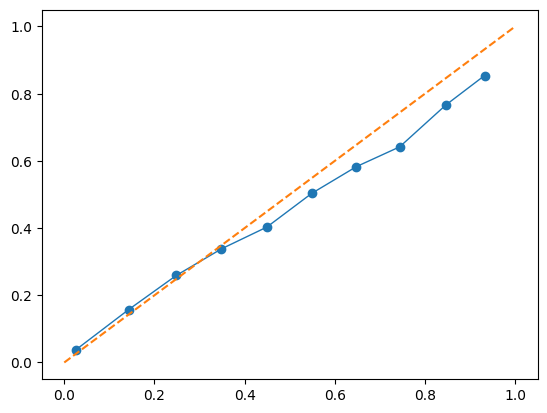

In [169]:
plt.plot(prob_pred,
         prob_true, 
         marker='o', 
         linewidth=1, 
         label='Roberta')
 
#Plot the Perfectly Calibrated by Adding the 45-degree line to the plot
plt.plot([0, 1], 
         [0, 1], 
         linestyle='--', 
         label='Perfectly Calibrated')